Reddit Data on Dementia

Data collection

In [ ]:
pip install praw


In [ ]:
import praw

reddit = praw.Reddit(
    client_id="xyx",
    client_secret="wyx",
    user_agent="http://localhost:8080"
)

subreddits = reddit.subreddit('Alzheimers+AlzheimersSupport+dementia+AlzheimersGroup')

file_path = 'reddit_comments.txt'


with open(file_path, 'w', encoding='utf-8') as file:
  
    for submission in subreddits.new(limit=None):
        submission.comments.replace_more(limit=None)  
        
        for comment in submission.comments.list():
  
            comment_data = {
                'submission_id': submission.id,
                'comment_id': comment.id,
                'author': comment.author.name if comment.author else '[deleted]',
                'text': comment.body,
                'created_utc': comment.created_utc,
                'permalink': comment.permalink,
            }
            
       
            file.write(str(comment_data) + '\n')



In [ ]:
with open('reddit_comments.txt', 'r') as file:
    content = file.read()


Clean and preprocess data

In [ ]:
import csv
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

def preprocess_text(text):
    text = re.sub(r'http\S+|www\S+', '', text)
    
    text = re.sub(r'[^a-zA-Z\s]', '', text)
  
    tokens = nltk.word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token.lower() not in stop_words]
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    
    preprocessed_text = ' '.join(tokens)
    
    return preprocessed_text

preprocessed_comments = []
for comment in comments:
    preprocessed_comment = {
        'comment_id': comment['comment_id'],
        'preprocessed_text': preprocess_text(comment['text'])
    }
    preprocessed_comments.append(preprocessed_comment)

#save the clean comments
csv_file = 'preprocessed_comments.csv'
fieldnames = ['comment_id', 'preprocessed_text']

with open(csv_file, 'w', newline='') as file:
    writer = csv.DictWriter(file, fieldnames=fieldnames)
    writer.writeheader()
    writer.writerows(preprocessed_comments)


SENTIMENT ANALYSIS

In [ ]:
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer

nltk.download('vader_lexicon')

def analyze_sentiment(text):
    analyzer = SentimentIntensityAnalyzer()
    sentiment_scores = analyzer.polarity_scores(text)
    
    compound_score = sentiment_scores['compound']
    if compound_score >= 0.05:
        sentiment = 'positive'
    elif compound_score <= -0.05:
        sentiment = 'negative'
    else:
        sentiment = 'neutral'
    
    return sentiment

for comment in preprocessed_comments:
    preprocessed_text = comment['preprocessed_text']
    sentiment = analyze_sentiment(preprocessed_text)
    comment['sentiment'] = sentiment

csv_file_with_sentiment = 'preprocessed_comments_with_sentiment.csv'
fieldnames_with_sentiment = ['comment_id', 'preprocessed_text', 'sentiment']

with open(csv_file_with_sentiment, 'w', newline='') as file:
    writer = csv.DictWriter(file, fieldnames=fieldnames_with_sentiment)
    writer.writeheader()
    writer.writerows(preprocessed_comments)


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


TOPPIC MODELLING

In [ ]:
import gensim
from gensim import corpora

preprocessed_texts = [comment['preprocessed_text'] for comment in preprocessed_comments]
dictionary = corpora.Dictionary([text.split() for text in preprocessed_texts])
corpus = [dictionary.doc2bow(text.split()) for text in preprocessed_texts]

#  LDA model
num_topics = 5  
lda_model = gensim.models.LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, passes=10)

#  topics and their associated keywords
for idx, topic in lda_model.print_topics():
    print(f'Topic #{idx + 1}: {topic}')

# dominant topic for each comment
dominant_topics = []
for comment_bow in corpus:
    topic_distribution = lda_model.get_document_topics(comment_bow)
    dominant_topic = max(topic_distribution, key=lambda x: x[1])
    dominant_topics.append(dominant_topic[0])


for i, comment in enumerate(preprocessed_comments):
    comment['dominant_topic'] = dominant_topics[i]

#  CSV file
csv_file_with_topics = 'preprocessed_comments_with_topics.csv'
fieldnames_with_topics = ['comment_id', 'preprocessed_text', 'sentiment', 'dominant_topic']

with open(csv_file_with_topics, 'w', newline='') as file:
    writer = csv.DictWriter(file, fieldnames=fieldnames_with_topics)
    writer.writeheader()
    writer.writerows(preprocessed_comments)


USER SEGMENTATION

In [ ]:
caregiver_comments = []
patient_comments = []
family_member_comments = []
healthcare_professional_comments = []
default_comments = []


# Iterate through the comments
for comment in comments:
    text = comment["text"].lower()
    
    # keywords that may be indicating the role or relationship
    if "caregiver" in text or "caregiving" in text:
        caregiver_comments.append(comment)
    elif "patient" in text:
        patient_comments.append(comment)
    elif "family member" in text:
        family_member_comments.append(comment)
    elif "healthcare professional" in text or "doctor" in text or "nurse" in text:
        healthcare_professional_comments.append(comment)
    else:
      
        default_comments.append(comment)


In [ ]:
import csv
file_path = "segmented_comments.csv"
fieldnames = ["Role", "Comment"]
with open(file_path, "w", newline="") as csvfile:
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)

    writer.writeheader()
    
    # caregiver comments
    for comment in caregiver_comments:
        writer.writerow({"Role": "Caregiver", "Comment": comment["text"]})
    
    #  patient comments
    for comment in patient_comments:
        writer.writerow({"Role": "Patient", "Comment": comment["text"]})
    
    #  family member comms
    for comment in family_member_comments:
        writer.writerow({"Role": "Family Member", "Comment": comment["text"]})
    
    # the healthcare professional comments
    for comment in healthcare_professional_comments:
        writer.writerow({"Role": "Healthcare Professional", "Comment": comment["text"]})
    
    # Write the default comments
    for comment in default_comments:
        writer.writerow({"Role": "Default", "Comment": comment["text"]})



Segmented comments have been saved to segmented_comments.csv.


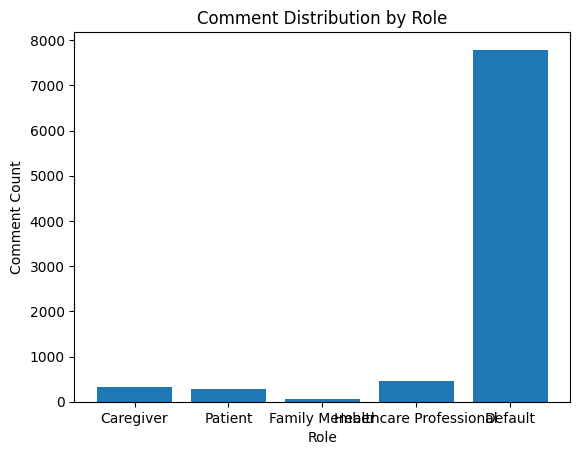

In [ ]:
import matplotlib.pyplot as plt

role_counts = {
    "Caregiver": len(caregiver_comments),
    "Patient": len(patient_comments),
    "Family Member": len(family_member_comments),
    "Healthcare Professional": len(healthcare_professional_comments),
    "Default": len(default_comments)
}

roles = list(role_counts.keys())
comment_counts = list(role_counts.values())

# histogram with the number of comments per each category
plt.bar(roles, comment_counts)
plt.title("Comment Distribution by Role")
plt.xlabel("Role")
plt.ylabel("Comment Count")
plt.show()


In [ ]:
from nltk.sentiment import SentimentIntensityAnalyzer

# we pwrform a SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()

sentiment_scores = {}

caregiver_sentiment = [sia.polarity_scores(comment["text"])["compound"] for comment in caregiver_comments]
sentiment_scores["Caregiver"] = sum(caregiver_sentiment) / len(caregiver_sentiment)

patient_sentiment = [sia.polarity_scores(comment["text"])["compound"] for comment in patient_comments]
sentiment_scores["Patient"] = sum(patient_sentiment) / len(patient_sentiment)

family_member_sentiment = [sia.polarity_scores(comment["text"])["compound"] for comment in family_member_comments]
sentiment_scores["Family Member"] = sum(family_member_sentiment) / len(family_member_sentiment)

healthcare_professional_sentiment = [sia.polarity_scores(comment["text"])["compound"] for comment in healthcare_professional_comments]
sentiment_scores["Healthcare Professional"] = sum(healthcare_professional_sentiment) / len(healthcare_professional_sentiment)

default_sentiment = [sia.polarity_scores(comment["text"])["compound"] for comment in default_comments]
sentiment_scores["Default"] = sum(default_sentiment) / len(default_sentiment)

for category, score in sentiment_scores.items():
    print(f"{category}: {score}")


Caregiver: 0.4422164634146342
Patient: 0.21479964539007088
Family Member: 0.30862753623188405
Healthcare Professional: 0.23437893569844806
Default: 0.17595267753948807


In [1]:


# sentiment per data
df = pd.read_csv('/content/preprocessed_comments_with_topics.csv')

sentiment_counts = df['sentiment'].value_counts()

# Calculate the percentage for each sentiment value
sentiment_percentages = (sentiment_counts / len(df)) * 100

print(sentiment_percentages)


positive    50.801839
neutral     27.587754
negative    21.610407
Name: sentiment, dtype: float64
